In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize


def zscore(series):
    return (series - series.mean()) / series.std()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid(x, k=1, x0=0):
    return 1 / (1 + np.exp(-k * (x - x0)))


def adjusted_sigmoid(x, f_min=0.01, f_max=0.1, k=1, x0=0):
    return f_min + (f_max - f_min) * sigmoid(x, k=k, x0=x0)


def global_sigmoid(x, f_min, f_max, k=1, x0=0):
    if x > 0:
        return adjusted_sigmoid(x, f_min, f_max, k, x0)
    else:
        return adjusted_sigmoid(-x, f_min, f_max, k, x0)
    
    
def calculate_markout(d, v, f, p):
    m = d * v * (f - p)
    return m


def buy_fee(x,  f_min, f_max, w_buy):
    return min(f_max, f_min + w_buy * max(0, x))


def sell_fee(x,  f_min, f_max, w_sell):
    return min(f_max, f_min - w_sell * min(0, x))


def cost_function_buy(k, delta_ps, f_min, f_max, w_buy, x0):
    sigmoid_fees = np.array([adjusted_sigmoid(x, f_min, f_max, k, x0) for x in delta_ps])
    linear_fees = np.array([buy_fee(x,  f_min, f_max, w_buy) for x in delta_ps])
    return np.sum((sigmoid_fees - linear_fees) ** 2)


def cost_function_sell(k, delta_ps, f_min, f_max, w_sell, x0):
    sigmoid_fees = np.array([adjusted_sigmoid(-x, f_min, f_max, k, x0) for x in delta_ps])
    linear_fees = np.array([sell_fee(x,  f_min, f_max, w_sell) for x in delta_ps])
    return np.sum((sigmoid_fees - linear_fees) ** 2)


data_p1 = pd.read_pickle('data/Merged_CEX_DEX_v2_p1.pkl')
data_p2 = pd.read_pickle('data/Merged_CEX_DEX_v2_p2.pkl')
data_p3 = pd.read_pickle('data/Merged_CEX_DEX_v2_p3.pkl')

data_p1['time'] = pd.to_datetime(data_p1['time'])
data_p2['time'] = pd.to_datetime(data_p2['time'])
data_p3['time'] = pd.to_datetime(data_p3['time'])

data = pd.concat([data_p1, data_p2, data_p3])
data = data.rename(columns={'LVR_clean': 'price_diff', 'LVR': 'arb_pnl' })
data = data.sort_values('time')

In [40]:
data['impermanent_loss'] = (2 * np.sqrt(data['price_dex'].shift(1) / data['price_dex']) / (1 + data['price_dex'].shift(1) / data['price_dex']) - 1).fillna(0)
data['LVR_nbtoken']= data['arb_pnl']/data['price_dex']
data['avg_gas']    = data['gasUsed'] * data['gasPrice_eth'].rolling(100).mean() * data['price_dex']
data['arb_fee']    = (np.abs(2*data['arb_pnl']) - (data['tcost_usd'] - data['avg_gas']))*100 / data['amountUSD']
data['LVR_zscore'] = zscore(data['arb_pnl'])
data['std']             = data['price_dex'].rolling(100).std()
data['mean_rol_amount'] = data['amountUSD'].rolling(10).mean()
data['rol_amountUSD']   = data['amountUSD'].rolling(100).sum()

# can be seen as looking ahead but in a DEX we can compute it aheat with the liquidity and the amount
data['price_impact']    = (data['price_dex'].pct_change(1).shift(-1)*100).abs()

data['time_diff']          = data['time'].diff().dt.total_seconds().fillna(0)

data['rol_1min_span']      = data['time_diff'].rolling(window=60, min_periods=1).sum() 
data['rol_1m_trade_count'] = data['time'].rolling(window=60, min_periods=1).count()
data['lambda_1min']        = data['rol_1m_trade_count'] / data['rol_1min_span']
data['lambda_1min'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)

data['rol_5min_span']      = data['time_diff'].rolling(window=60*5, min_periods=1).sum() 
data['rol_5m_trade_count'] = data['time'].rolling(window=60*5, min_periods=1).count()
data['lambda_5min']        = data['rol_5m_trade_count'] / data['rol_5min_span']
data['lambda_5min'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)
data = data.drop(columns=['time_diff'])

data['target_fee'] = -np.tanh(np.sign(data['amount1']) * data['arb_fee']/100)

data = data.dropna()

features = [#'LVR_nbtoken',
            'price_diff', 'arb_pnl', 'std', 
            #'mean_rol_amount', 'avg_gas', 'price_impact', 'rol_amountUSD',
            #'lambda_1min', 'rol_1min_span', 'rol_1m_trade_count', 
            #'lambda_5min', 'rol_5min_span', 'rol_5m_trade_count', 
            #'amountUSD',
            ]
target = 'tcost_usd'

lower_bound = data[features].quantile(0.10)
upper_bound = data[features].quantile(0.90)
filtered_indices = data[features].apply(lambda x: x.between(lower_bound[x.name], upper_bound[x.name])).all(axis=1)
data_filtered = data.loc[filtered_indices].copy()

# max and min fee in %
f_min = 0.01
f_max = 0.1

params = {}
for f in features:
    params[f] = {'lower_quantile': 0.1, 'upper_quantile': 0.9}
    
data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,mean_rol_amount,rol_amountUSD,price_impact,rol_1min_span,rol_1m_trade_count,lambda_1min,rol_5min_span,rol_5m_trade_count,lambda_5min,target_fee
99,6318.571324,-2.753365,6310.474821,0xf3e01e963796ad8ed86fc7dbce195eaa3aaf4e4a,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,414642,1.216669e+10,1.216669e-08,...,31679.388299,3.274054e+06,0.009999,1032.0,60.0,0.058140,1404.0,100.0,0.071225,0.002317
100,-160.477545,0.070000,160.352835,0xea08db5fb88d6f1f4978400ec2c57d9a29e85e99,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xef5edb29b4eb20501de89718daa7d1ad108efb66,1.704069e+09,445316,1.225569e+10,1.225569e-08,...,31196.151489,3.256138e+06,0.000000,1032.0,60.0,0.058140,1404.0,101.0,0.071937,-0.076640
101,-99.931075,0.043590,99.853435,0x5e969b786482489323c94b8abc4eb03a41da527a,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x5e969b786482489323c94b8abc4eb03a41da527a,1.704069e+09,270277,1.144304e+10,1.144304e-08,...,31203.846347,3.255538e+06,0.010000,1044.0,60.0,0.057471,1428.0,102.0,0.071429,-0.078952
102,1500.000000,-0.653642,1498.084492,0xfcb40a45a51a31f568ef39e0f6dfe5f3b21711df,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,303561,1.095438e+10,1.095438e-08,...,20749.062023,3.232065e+06,0.000000,1056.0,60.0,0.056818,1476.0,103.0,0.069783,0.006794
103,-550.210323,0.240000,549.781949,0xcdb343941111e306d71f141689b5b69d07ca6f59,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,306333,1.182152e+10,1.182152e-08,...,20425.349686,3.231848e+06,0.000000,1080.0,60.0,0.055556,1500.0,104.0,0.069333,-0.016415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187221,-16804.135320,7.369011,16802.205053,0x4066e9bd5618373d2da7a1cb7bba03ef800875ee,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,1.706746e+09,217474,8.602831e+10,8.602831e-08,...,18697.005457,1.080576e+06,0.000000,1128.0,60.0,0.053191,4080.0,300.0,0.073529,0.001753
187222,-2280.293805,1.000000,2280.074254,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,1.706746e+09,284804,3.171776e+10,3.171776e-08,...,18890.788832,1.082558e+06,0.000000,1116.0,60.0,0.053763,4092.0,300.0,0.073314,0.001822
187223,15000.000000,-6.571360,14990.873565,0xcf99f91f0d834f26b8e7267ee99203bef3648edd,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,280947,2.010458e+10,2.010458e-08,...,19990.184415,1.018821e+06,0.070021,1128.0,60.0,0.053191,4116.0,300.0,0.072886,0.000216
187225,1000.000000,-0.437797,999.056241,0xe86866e5f456d5f986cec61e43bfcec6065b80eb,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,279656,2.268775e+10,2.268775e-08,...,20063.044481,1.015755e+06,0.000000,1140.0,60.0,0.052632,4104.0,300.0,0.073099,0.002916


In [41]:
# Get the factor weightings

X_filtered = data_filtered[features]
y_filtered = data_filtered[target]
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

model = RandomForestRegressor(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

feature_importances = model.feature_importances_ / model.feature_importances_.sum()
features_importance_normalized = {feature: importance for feature, importance in zip(features, feature_importances)}

In [42]:
## !! the price difference is stationnary because we cans stipulate the the dex and cex price are stationnary wich makes total sense 
# cause they are the same asset and arrbitragers always move to remove the differnce
# Then we dont really need to care of using the zscore also because we will redo a different calibration for a different pair 
# (so we dont need to normalize the time series of the difference)

buy_subset = data_filtered[data_filtered['amount1'] < 0].copy()
sell_subset = data_filtered[data_filtered['amount1'] > 0].copy()

for f in features:   
    low_q  = params[f]['lower_quantile']
    high_q = params[f]['upper_quantile']

    scale_min = data_filtered[f].quantile(high_q)
    scale_max = data_filtered[f].quantile(low_q)
    delta_p = pd.DataFrame({'delta_p': np.linspace(scale_min, scale_max, 1000)}) 

    if len(sell_subset[sell_subset[f]<0])>0:
        sell_max_fee_q = sell_subset[sell_subset[f]<0][f].quantile(low_q)
        sell_min_fee_q = sell_subset[sell_subset[f]<0][f].quantile(high_q)
    else :
        sell_max_fee_q = sell_subset[sell_subset[f]>0][f].quantile(low_q)
        sell_min_fee_q = sell_subset[sell_subset[f]>0][f].quantile(high_q)
        
    if len(buy_subset[buy_subset[f]>0])>0:
        buy_max_fee_q  = buy_subset[buy_subset[f]>0][f].quantile(low_q)
        buy_min_fee_q  = buy_subset[buy_subset[f]>0][f].quantile(high_q)
    else:
        buy_max_fee_q  = buy_subset[buy_subset[f]<0][f].quantile(low_q)
        buy_min_fee_q  = buy_subset[buy_subset[f]<0][f].quantile(high_q)

    w_buy  = np.abs((f_max-f_min)/buy_min_fee_q)
    w_sell = np.abs((f_max-f_min)/sell_max_fee_q)

    x0_sell = np.abs(sell_max_fee_q/2)
    x0_buy = np.abs(buy_min_fee_q/2)

    delta_ps = np.linspace(scale_min, scale_max, 1000)
    result_buy  = minimize(cost_function_buy,  1, args=(delta_ps, f_min, f_max, w_buy,  x0_buy))
    result_sell = minimize(cost_function_sell, 1, args=(delta_ps, f_min, f_max, w_sell, x0_sell))

    k_buy  = result_buy.x[0]
    k_sell = result_sell.x[0]

    print(f"Optimized k for buying fees : {k_buy}")
    print(f"Optimized k for selling fees: {k_sell}")

    buy_subset[f'{f}_fee'] = buy_subset[f].apply(lambda x: adjusted_sigmoid(x, f_min, f_max, k_buy, x0_buy))
    sell_subset[f'{f}_fee'] = -sell_subset[f].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k_sell, x0_sell))

combined_data = pd.concat([buy_subset, sell_subset])

# Apply feature importances as weights
for f in features:
    weight = features_importance_normalized[f]
    combined_data[f'{f}_weighted_fee'] = combined_data[f'{f}_fee'] * weight

# sum weighted fees to get a combined fee
weighted_fee_columns = [f'{f}_weighted_fee' for f in features]
combined_data['combined_fee'] = combined_data[weighted_fee_columns].sum(axis=1)
combined_data['target_fee_usd'] = combined_data['target_fee'] * combined_data['amount0']



Optimized k for buying fees : 1.2136914232580478
Optimized k for selling fees: 0.9922105111540315
Optimized k for buying fees : 67.48731036964405
Optimized k for selling fees: 0.36988798648632476
Optimized k for buying fees : 0.31612967604023967
Optimized k for selling fees: 5.339897931201474


In [43]:
metrics = combined_data.resample('1Min', on='time_dex').agg({
    'price_dex'           : 'ohlc',
    'amount0'             : 'sum',
    'amount1'             : 'sum',
    'amountUSD'           : 'sum',
    'price_diff'          : 'last',
    'arb_pnl'             : 'sum',
    'price_impact'        : 'sum', # or mean maybe
    'lambda_5min'         : 'last',
    'lambda_1min'         : 'last',
    'impermanent_loss'    : 'sum',
    'tcost_usd'           : 'sum',
    'target_fee_usd'      : 'sum',
    'combined_fee'        : 'sum',
})
metrics.columns = metrics.columns.droplevel(0)
metrics = metrics.rename(columns={'amountUSD': 'volumeUSD'})
metrics['1m_volumeUSD'] = metrics['volumeUSD'].rolling(window=60).sum()

metrics['future_close'] = metrics['close'].shift(-60)
metrics = metrics.dropna()

metrics['markout'] = metrics.apply(lambda x: calculate_markout(d=np.sign(x['amount0']), v=x['volumeUSD'], f=x['future_close'], p=x['close']), axis=1)

pool_fee_rate = 0.05/100

metrics['trade_direction'] = np.sign(metrics['amount0'])
metrics['cfee'] = pool_fee_rate * metrics['volumeUSD']
metrics['dfee'] = metrics['combined_fee']/100 * metrics['volumeUSD']

metrics['cpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['cfee'].abs()
metrics['dpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['dfee'].abs()

metrics['cfee_cumul'] = metrics['cfee'].cumsum()
metrics['dfee_cumul'] = metrics['dfee'].cumsum()
metrics['avg_7m_cfee'] = (metrics['volumeUSD'] * pool_fee_rate).rolling(window=7).mean()

metrics['cpnl_5m_positive'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['cpnl_5m_negative'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['c%_toxic_flow_ma_7m'] = (metrics['cpnl_5m_negative'] / (metrics['cpnl_5m_negative'] + metrics['cpnl_5m_positive'])).rolling(window=7).mean()

metrics['dpnl_5m_positive'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['dpnl_5m_negative'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['d%_toxic_flow_ma_7m'] = (metrics['dpnl_5m_negative'] / (metrics['dpnl_5m_negative'] + metrics['dpnl_5m_positive'])).rolling(window=7).mean()

metrics.dropna()

,open,high,low,close,amount0,amount1,volumeUSD,price_diff,arb_pnl,price_impact,...,dpnl,cfee_cumul,dfee_cumul,avg_7m_cfee,cpnl_5m_positive,cpnl_5m_negative,c%_toxic_flow_ma_7m,dpnl_5m_positive,dpnl_5m_negative,d%_toxic_flow_ma_7m
time_dex,,,,,,,,,,,,,,,,,,,,,
2024-01-01 01:39:00,2303.340051,2303.340051,2303.340051,2303.340051,-572.968411,0.249118,1562.928747,-0.160051,-0.271351,0.000000,...,0.061438,153.043864,-40.733873,8.773969,11.718841,0.0,0.0,9.505098,0.0,0.0
2024-01-01 01:40:00,2303.340051,2303.340051,2303.340051,2303.340051,8407.717226,-3.648690,8416.102555,0.429949,-1.568750,0.039990,...,2.326105,157.251915,-39.329243,1.748888,14.071625,0.0,0.0,10.579282,0.0,0.0
2024-01-01 01:49:00,2304.031122,2304.261525,2304.031122,2304.261525,38558.446265,-16.725895,41598.890504,0.598475,-3.830841,0.010000,...,54.001422,178.051360,14.672179,4.687740,32.096895,0.0,0.0,60.078727,0.0,0.0
2024-01-01 01:50:00,2304.261525,2304.261525,2304.261525,2304.261525,3299.877828,-1.431301,3755.355883,-0.171525,-0.751467,0.000000,...,2.809504,179.929038,17.481683,4.559303,33.516514,0.0,0.0,62.561413,0.0,0.0
2024-01-01 01:51:00,2304.261525,2304.261525,2304.261525,2304.261525,-690.915600,0.300000,690.295180,-0.171525,-0.051458,0.000000,...,0.178321,180.274186,17.303362,4.310855,28.933261,0.0,0.0,59.376789,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 22:40:00,2281.563014,2281.563014,2281.563014,2281.563014,-3835.015144,1.681846,4102.304057,0.396986,0.051495,0.000000,...,1.506742,448135.022511,85001.233383,11.485139,55.169189,0.0,0.0,46.911156,0.0,0.0
2024-01-31 22:41:00,2281.563014,2281.563014,2281.563014,2281.563014,-11008.121934,4.831965,30985.693922,-0.473014,-2.285588,0.000000,...,3.684150,448150.515358,85000.288615,12.737990,61.068145,0.0,0.0,25.781123,0.0,0.0
2024-01-31 22:55:00,2284.302396,2284.530826,2284.302396,2284.302396,-3401.772389,1.493047,17493.500644,0.587604,1.612475,0.039998,...,1.441604,448159.262108,85002.187011,11.148618,48.722814,0.0,0.0,17.712698,0.0,0.0


In [44]:
print(f"The average constant fees is: {0.05}")
average_fee_positive = combined_data[combined_data['amount1'] > 0]['combined_fee'].mean()
average_fee_negative = combined_data[combined_data['amount1'] < 0]['combined_fee'].mean()

print(f"The average dynamic selling fees is: {round(average_fee_positive, 2)}")
print(f"The average dynamic buying  fees is: {round(average_fee_negative, 2)}")
print('')
print(f"The total constant fees are: {round(metrics['cfee'].sum(), 2)}")
print(f"The total dynamic  fees are: {round(metrics['dfee'].sum(), 2)}")
print('')
print(f"The total pnl with c are: {round(metrics['cpnl'].sum(), 2)}")
print(f"The total pnl with d are: {round(metrics['dpnl'].sum(), 2)}")
print('')
print(f"The % of toxic pnl flow in constant fee: {metrics['c%_toxic_flow_ma_7m'].sum().round(2)}")
print(f"The % of toxic pnl flow in dynamic  fee: {metrics['d%_toxic_flow_ma_7m'].sum().round(2)}")
print('')
print('The 1 min markout pnl is: ', round(metrics['markout'].sum(), 2))
print('')
print('The impermanent loss is: ', round(metrics['impermanent_loss'].sum(), 2))
print('')
print('Average tcost_usd: ', round(metrics['tcost_usd'].mean(), 2))
print('Average target_fee_usd: ', round(metrics['target_fee_usd'].mean(), 2))
print('Average combined_fee: ', round(metrics['combined_fee'].mean(), 2))

# only 9% of the fees that we quote are in the range of the fee the arbitrager will be willing to pay
accuracy = (metrics['dfee'].abs() < metrics['tcost_usd']).mean()

print(f'{accuracy*100:.2f}% of the dynamic fees are in the range of the constant fee the arbitrager will be willing to pay')
print('Average accuracy of the fee: ', round(accuracy*100, 2))

# can we know whats gonna be the price impact after this dynamic fee:
# we need to now what will be the liquidity in such pools at the permanent regime 
# this will depend on the profitability (returns of LP) of LP. 
# In average the liquidty is provided in a pool such that the returns are the same as a constant pool 
# we can then match the liquidity corresponding to this profitability and find the price impact at a given liquidity level for a given amount to swap

The average constant fees is: 0.05
The average dynamic selling fees is: -0.03
The average dynamic buying  fees is: 0.04

The total constant fees are: 448242.05
The total dynamic  fees are: 84687.75

The total pnl with c are: 448157.07
The total pnl with d are: 666590.51

The % of toxic pnl flow in constant fee: -721.22
The % of toxic pnl flow in dynamic  fee: -85.39

The 1 min markout pnl is:  899540017.43

The impermanent loss is:  -0.0

Average tcost_usd:  82.14
Average target_fee_usd:  32.66
Average combined_fee:  0.0
87.80% of the dynamic fees are in the range of the constant fee the arbitrager will be willing to pay
Average accuracy of the fee:  87.8


<Axes: >

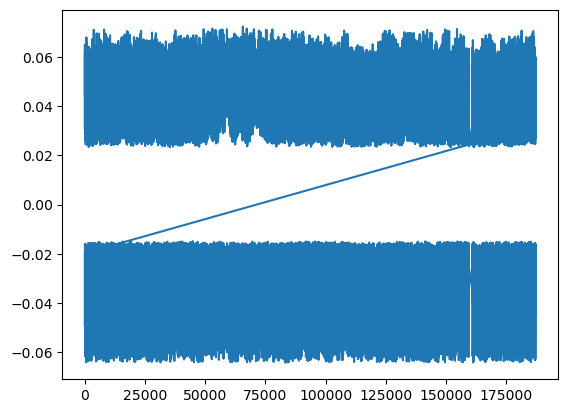

In [45]:
combined_data['combined_fee'].plot()

Optimized k for buying fees : 2.278735044662986
Optimized k for selling fees: 0.05001922298557547


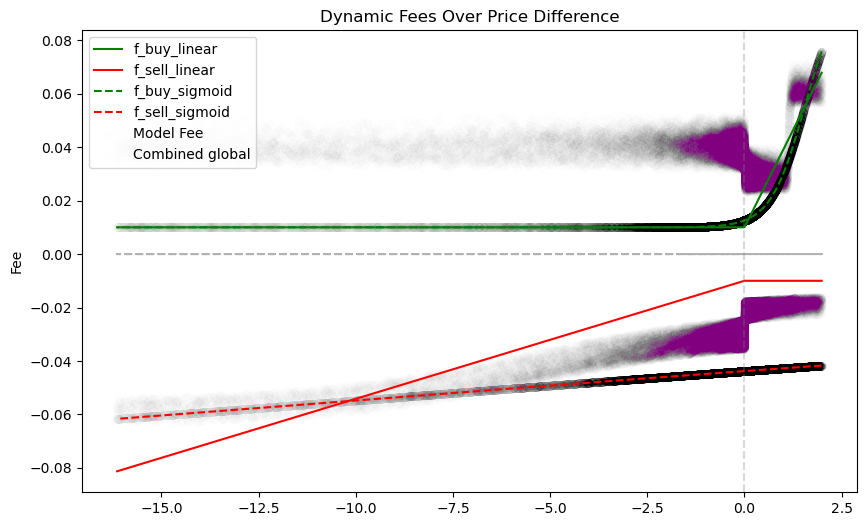

In [46]:
import matplotlib.pyplot as plt

feat = 'arb_pnl' # 'arb_pnl'
f_min  = 0.01
f_max  = 0.1
low_q  = 0.05
high_q = 0.95


scale_min = data_filtered[feat].quantile(high_q)
scale_max = data_filtered[feat].quantile(low_q)
delta_p = pd.DataFrame({'delta_p': np.linspace(scale_min, scale_max, 1000)})

## !! the price difference is stationnary because we cans stipulate the the dex and cex price are stationnary wich makes total sense 
# cause they are the same asset and arrbitragers always move to remove the differnce
# Then we dont really need to care of using the zscore also because we will redo a different calibration for a different pair 
# (so we dont need to normalize the time series of the difference)


# Segment the data based on 'amount1'
buy_subset = data_filtered[data_filtered['amount1'] < 0].copy()
sell_subset = data_filtered[data_filtered['amount1'] > 0].copy()

if len(sell_subset[sell_subset[feat]<0])>0:
    sell_max_fee_q = sell_subset[sell_subset[feat]<0][feat].quantile(low_q)
    sell_min_fee_q = sell_subset[sell_subset[feat]<0][feat].quantile(high_q)
else :
    sell_max_fee_q = sell_subset[sell_subset[feat]>0][feat].quantile(low_q)
    sell_min_fee_q = sell_subset[sell_subset[feat]>0][feat].quantile(high_q)
    
if len(buy_subset[buy_subset[feat]>0])>0:
    buy_max_fee_q  = buy_subset[buy_subset[feat]>0][feat].quantile(low_q)
    buy_min_fee_q  = buy_subset[buy_subset[feat]>0][feat].quantile(high_q)
else:
    buy_max_fee_q  = buy_subset[buy_subset[feat]<0][feat].quantile(low_q)
    buy_min_fee_q  = buy_subset[buy_subset[feat]<0][feat].quantile(high_q)

w_buy  = np.abs((f_max-f_min)/buy_min_fee_q)
w_sell = np.abs((f_max-f_min)/sell_max_fee_q)

x0_sell = np.abs(sell_max_fee_q/2)
x0_buy = np.abs(buy_min_fee_q/2)

delta_ps = np.linspace(scale_min, scale_max, 1000)
result_buy  = minimize(cost_function_buy,  1, args=(delta_ps, f_min, f_max, w_buy,  x0_buy))
result_sell = minimize(cost_function_sell, 1, args=(delta_ps, f_min, f_max, w_sell, x0_sell))

k_buy  = result_buy.x[0]
k_sell = result_sell.x[0]

print(f"Optimized k for buying fees : {k_buy}")
print(f"Optimized k for selling fees: {k_sell}")

# Apply the fees
buy_subset['model_fee'] = buy_subset[feat].apply(lambda x: adjusted_sigmoid(x, f_min, f_max, k_buy, x0_buy))
sell_subset['model_fee'] = -sell_subset[feat].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k_sell, x0_sell))

fus_data = pd.concat([buy_subset, sell_subset])

# plot the fees and the model fee
plt.figure(figsize=(10, 6))

plt.plot(delta_p['delta_p'],  delta_p['delta_p'].apply(lambda x: min(f_max, f_min + w_buy * max(0, x))),  label='f_buy_linear', color='green')
plt.plot(delta_p['delta_p'], -delta_p['delta_p'].apply(lambda x: min(f_max, f_min - w_sell * min(0, x))), label='f_sell_linear', color='red')
plt.plot(delta_p['delta_p'],  delta_p['delta_p'].apply(lambda x: adjusted_sigmoid(x,  f_min, f_max, k_buy,  x0_buy)),  label='f_buy_sigmoid',  linestyle='--', color='green')
plt.plot(delta_p['delta_p'], -delta_p['delta_p'].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k_sell, x0_sell)), label='f_sell_sigmoid', linestyle='--', color='red')

filtered_plot = (fus_data[feat] >= fus_data[feat].quantile(low_q)) & (fus_data[feat] <= fus_data[feat].quantile(high_q))
plt.scatter(fus_data[filtered_plot][feat], fus_data[filtered_plot]['model_fee'], alpha=0.005, color='black', label='Model Fee')

comb_plot = (combined_data[feat] >= combined_data[feat].quantile(low_q)) & (combined_data[feat] <= combined_data[feat].quantile(high_q))
plt.scatter(combined_data[comb_plot][feat], combined_data[comb_plot]['combined_fee'], alpha=0.005, color='purple', label='Combined global')

plt.plot(fus_data[filtered_plot][feat], [0]*len(fus_data[filtered_plot]), linestyle='--', alpha=0.3, color='black')
plt.axvline(0, color='gray', linestyle='--', alpha=0.3) 

plt.ylabel('Fee')
plt.legend()
plt.title('Dynamic Fees Over Price Difference')
plt.show()

In [47]:
combined_data['combined_fee']

99        0.044232
102       0.045621
105       0.045278
107       0.064847
108       0.030523
            ...   
187165   -0.029904
187217   -0.018805
187220   -0.028099
187221   -0.025425
187222   -0.024982
Name: combined_fee, Length: 104227, dtype: float64